In [89]:
!pip install transformers tensorflow scikit-learn pandas
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, SimpleRNN
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification

In [90]:
# Load the data
data = pd.read_csv('/content/semeval2016-task6-trainingdata.txt',encoding= 'latin1', delimiter='\t')

In [91]:
# Display the first few rows of the dataset
print(data.head(10))


    ID   Target                                              Tweet   Stance
0  101  Atheism  dear lord thank u for all of ur blessings forg...  AGAINST
1  102  Atheism  Blessed are the peacemakers, for they shall be...  AGAINST
2  103  Atheism  I am not conformed to this world. I am transfo...  AGAINST
3  104  Atheism  Salah should be prayed with #focus and #unders...  AGAINST
4  105  Atheism  And stay in your houses and do not display you...  AGAINST
5  106  Atheism  If we are unsure whether something is halal or...  AGAINST
6  107  Atheism  Papa God, i pray that You shower me with more ...  AGAINST
7  108  Atheism  Now that the SCOC has ruled Canadians have fre...    FAVOR
8  109  Atheism  Wow, unsubstantiated claims about spooks. Reme...     NONE
9  110  Atheism  RT "...That kind of modesty is too arrogant fo...     NONE


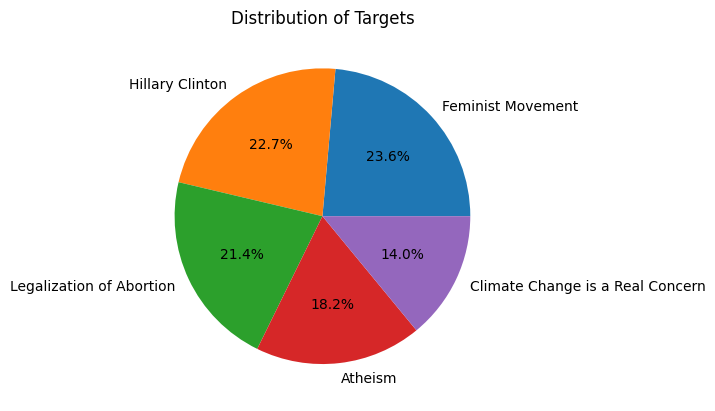

In [92]:
import matplotlib.pyplot as plt

# Count the occurrences of each target
target_counts = data['Target'].value_counts()

# Create a pie chart
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Targets')
plt.show()


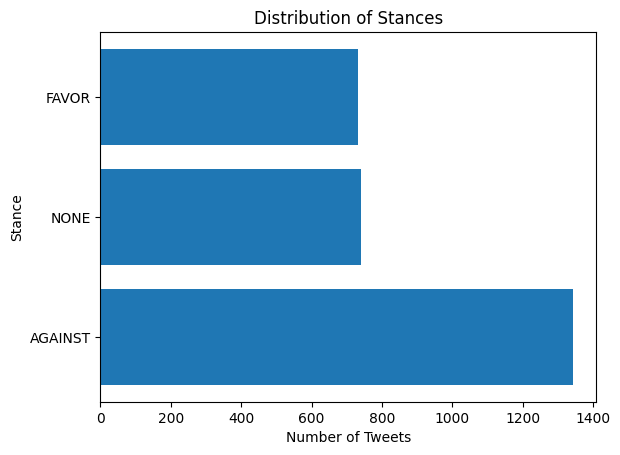

In [93]:
# Count the occurrences of each target
target_counts = data['Stance'].value_counts()

# Create a horizontal bar chart
plt.barh(target_counts.index, target_counts.values)
plt.xlabel('Number of Tweets')
plt.ylabel('Stance')
plt.title('Distribution of Stances')
plt.show()


In [94]:
# Preprocess the data
X = data['Tweet'].values
y = data['Stance'].values

In [95]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

In [96]:
# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
max_length = max([len(x) for x in sequences])
X = pad_sequences(sequences, maxlen=max_length, padding='post')

In [97]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Define the model architectures BERT
def create_bert_model():
    model = Sequential([
        Embedding(10000, 256, input_length=max_length),  # Increased embedding dimensions
        Bidirectional(LSTM(128, return_sequences=True)),  # Increased LSTM units
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),  # Increased dense units
        Dropout(0.3),  # Changed dropout rate
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train and evaluate the models
models = {
    'BERT': create_bert_model(),
}

In [99]:
# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [136]:
# Train and evaluate the models
models = {
    'BERT': create_bert_model(),
}

history = {}

for model_name, model in models.items():
    print(f"Training {model_name} model...")
    history[model_name] = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)  # Increased epochs and batch size
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(f"Results for {model_name} model:")
    print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
    print(f"Accuracy: {accuracy_score(y_true, y_pred_classes)}")

Training BERT model...
Epoch 1/3
57/57 [==============================] - 18s 245ms/step - loss: 1.0548 - accuracy: 0.4756 - val_loss: 1.0397 - val_accuracy: 0.4656
Epoch 2/3
57/57 [==============================] - 14s 243ms/step - loss: 0.8484 - accuracy: 0.5944 - val_loss: 0.9245 - val_accuracy: 0.5455
Epoch 3/3
18/18 [==============================] - 2s 74ms/step
Results for BERT model:
              precision    recall  f1-score   support

     AGAINST       0.70      0.61      0.65       268
       FAVOR       0.49      0.49      0.49       135
        NONE       0.55      0.66      0.60       160

    accuracy                           0.60       563
   macro avg       0.58      0.59      0.58       563
weighted avg       0.61      0.60      0.60       563

Accuracy: 0.5968028419182948


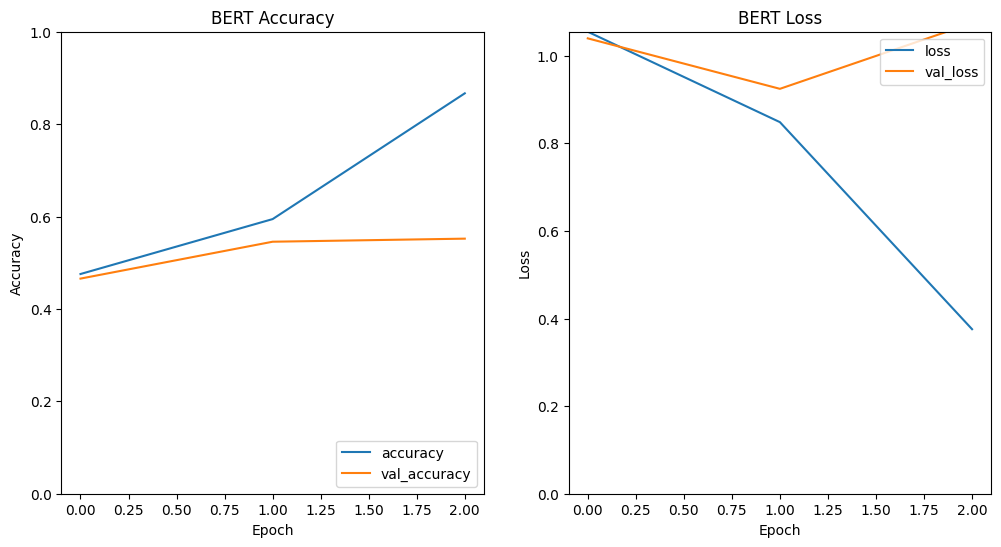

In [137]:
# Plot the results
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, max(history.history['loss'])])
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Loss')

    plt.show()

for model_name in models.keys():
    plot_history(history[model_name], model_name)

In [142]:
# Define the model architectures Bi-lstm
def create_bi_lstm_model():
    model = Sequential([
        Embedding(10000, 256, input_length=max_length),  # Increased embedding dimensions
        Bidirectional(LSTM(128, return_sequences=True)),  # Increased LSTM units
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),  # Increased dense units
        Dropout(0.3),  # Changed dropout rate
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train and evaluate the models
models = {
    'Bi-LSTM': create_bi_lstm_model(),
}

history = {}

for model_name, model in models.items():
    print(f"Training {model_name} model...")
    history[model_name] = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)  # Increased epochs and batch size
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(f"Results for {model_name} model:")
    print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
    print(f"Accuracy: {accuracy_score(y_true, y_pred_classes)}")



Training Bi-LSTM model...
Epoch 1/10
15/15 [==============================] - 12s 426ms/step - loss: 1.0638 - accuracy: 0.4733 - val_loss: 1.0581 - val_accuracy: 0.4656
Epoch 2/10
15/15 [==============================] - 8s 529ms/step - loss: 1.0316 - accuracy: 0.4800 - val_loss: 1.0357 - val_accuracy: 0.4656
Epoch 3/10
15/15 [==============================] - 5s 370ms/step - loss: 0.8727 - accuracy: 0.5811 - val_loss: 1.1342 - val_accuracy: 0.5322
Epoch 4/10
15/15 [==============================] - 7s 441ms/step - loss: 0.5518 - accuracy: 0.7967 - val_loss: 1.2001 - val_accuracy: 0.5588
Epoch 5/10
15/15 [==============================] - 7s 441ms/step - loss: 0.2375 - accuracy: 0.9333 - val_loss: 1.7272 - val_accuracy: 0.5410
Epoch 6/10
15/15 [==============================] - 6s 378ms/step - loss: 0.0908 - accuracy: 0.9717 - val_loss: 1.5746 - val_accuracy: 0.5632
Epoch 7/10
15/15 [==============================] - 7s 502ms/step - loss: 0.0644 - accuracy: 0.9800 - val_loss: 1.9495 - 

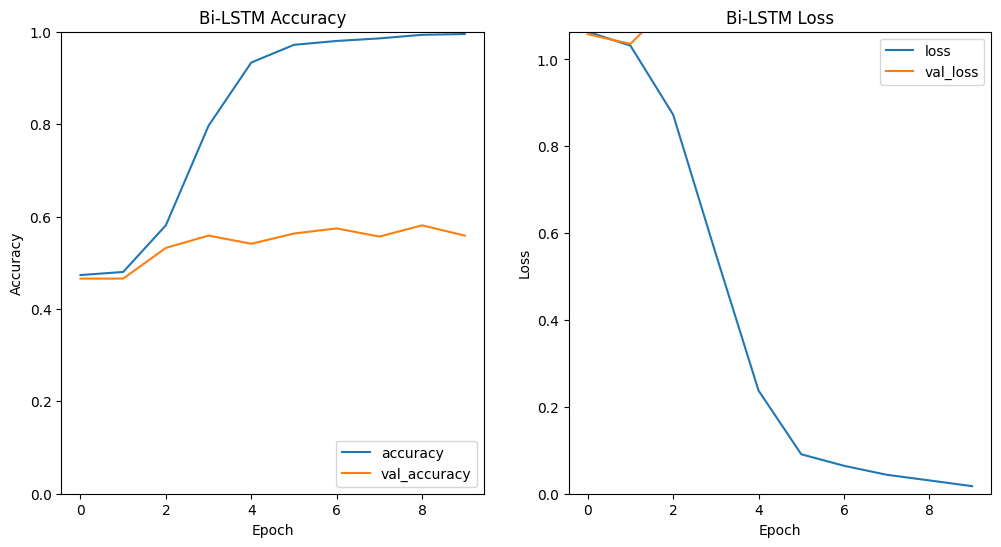

In [143]:
# Plot the results
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, max(history.history['loss'])])
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Loss')

    plt.show()

for model_name in models.keys():
    plot_history(history[model_name], model_name)

In [102]:
#CNN
def create_cnn_model():
    model = Sequential([
        Embedding(10000, 128, input_length=max_length),  # Increased embedding dimensions
        Conv1D(256, 3, activation='relu'),  # Changed kernel size and increased filters
        MaxPooling1D(pool_size=2),
        Conv1D(256, 3, activation='relu'),  # Changed kernel size and increased filters
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),  # Increased dense units
        Dropout(0.4),  # Changed dropout rate
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model# Train and evaluate the models
models = {
    'CNN': create_cnn_model(),
}

history = {}

for model_name, model in models.items():
    print(f"Training {model_name} model...")
    history[model_name] = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)  # Increased epochs and batch size
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print(f"Results for {model_name} model:")
    print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
    print(f"Accuracy: {accuracy_score(y_true, y_pred_classes)}")

Training CNN model...
Epoch 1/10
15/15 [==============================] - 5s 183ms/step - loss: 1.0608 - accuracy: 0.4761 - val_loss: 1.0567 - val_accuracy: 0.4656
Epoch 2/10
15/15 [==============================] - 2s 165ms/step - loss: 1.0245 - accuracy: 0.4800 - val_loss: 1.0470 - val_accuracy: 0.4656
Epoch 3/10
15/15 [==============================] - 2s 163ms/step - loss: 0.9608 - accuracy: 0.4800 - val_loss: 1.0043 - val_accuracy: 0.4656
Epoch 4/10
15/15 [==============================] - 3s 181ms/step - loss: 0.7601 - accuracy: 0.6122 - val_loss: 1.0372 - val_accuracy: 0.5477
Epoch 5/10
15/15 [==============================] - 4s 265ms/step - loss: 0.4275 - accuracy: 0.8806 - val_loss: 1.1554 - val_accuracy: 0.5432
Epoch 6/10
15/15 [==============================] - 2s 160ms/step - loss: 0.1395 - accuracy: 0.9606 - val_loss: 1.6059 - val_accuracy: 0.5410
Epoch 7/10
15/15 [==============================] - 2s 166ms/step - loss: 0.0333 - accuracy: 0.9928 - val_loss: 1.8638 - val_a

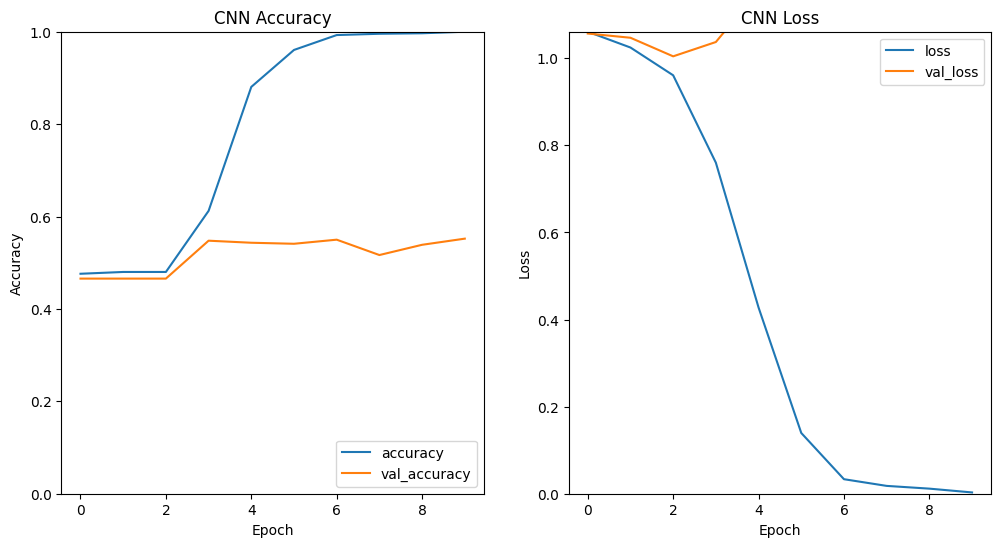

In [103]:
# Plot the results
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, max(history.history['loss'])])
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Loss')

    plt.show()

for model_name in models.keys():
    plot_history(history[model_name], model_name)